# Flow Matching from Scratch

Flow matching from scratch using [this paper](https://arxiv.org/abs/2412.06264) as a reference. Pages 4 - 6 should suffice to do this yourself, while the corresponding implementation by the authors can be found [here](https://github.com/facebookresearch/flow_matching/blob/main/examples/standalone_flow_matching.ipynb). This notebook contains the essential theory, leaving out as much background math as possible, and additional implementation details. 

> *Disclaimer*: Please refer to the papers I cite, as I’m not an expert in this field and have intentionally left out many details to focus on building intuition rather than aiming for mathematical precision.

## Prerequisites

Previous experience with (deep) generative modeling.


## Brief Intro to Flow Matching (FM)

Following a quote from Flow Matching Guide and Code [paper](https://arxiv.org/abs/2412.06264) by Y. Lipman *et al.*, the goal is to build a model capable of generating new samples from $q$, where $q$ is the target distribution from which the training dataset is sampled. Next, a clear distinction between the training and sampling (or generating) setting is given along with the questions one should ask. 

**(before) Training**: we have
- $q$: target distribution from which training dataset is sampled
- $p$: the source distribution (i.e a $\mathcal{N}(x | 0,\, I)$ in this example)
- $u_t^{\theta}$: an *untrained* neural net (more details on this later)

**Sampling (= generating)**: we have
- $p$: the source distribution from which we can sample (:= $\mathcal{N}(x | 0,\, I)$)
- $u_t^{\theta}$: a *trained* neural net

The (rather broad) remaining questions which willl be answered in the next section are:
- what does $u_t^{\theta}$ learn?
- how does $u_t^{\theta}$ learn?
- how can $p$ and $u_t^{\theta}$ be used to generate samples from $q$?

### FM Theory in Summary

#### Overview

For starters, know that $t \in \left[0, 1\right] $

1. FM starts by building a **probability path** $(p_t)_{0 \leq t \leq 1}$ from $p_{t=0} = p$ (i.e the source distr.) to $p_{t=1} = q$ (target distr.). The probability path describes the transformation of the source distribution into the target distribution, *but is doesn't tell us how*... In other words, given samples $p_{t=0}$ (i.e samples from our Gaussian distr.), how do we obtain the other distributions $p_{t}$ along the probability path? Such a *system* would allow us to (gradually) transform our standard Gaussian distribution into the target (data) distribution. 

2. We want the distribution $p_{t=\Delta t} = p_t$ at timestep $t = \Delta t$ such that we can "construct" the probability path. It should be clear that this probability path can serve as the **ground truth** during training. Knowing that at training time we have access to our data which is sampled from our target $p_{t=1} = q$, we could use a linear combination of $p_{t=0}$ and $p_{t=1}$ (= $q$) to get $p_{t=\Delta t}$.

$$X_t = t X_1 + (1-t) X_0 \sim p_t , \text{ where } X_0 \sim p_0 \text{ and } X_1 \sim p_1 $$

3. Next, FM provides a way to obtain $X_t$ using $u^{\theta}_t$ without having access to the dataset ($q_{t=1} = q$) used in the linear combination above. More specifically, $u^{\theta}_t$ represents a [velocity field](https://en.wikipedia.org/wiki/Flow_velocity) which we learn (or train) rather than learning the flow $\psi_t$ (from source $p_0$ to intermediate $p_t$, and eventually to $p_1 = q$) directly. Nonetheless, it is solving the ODE given below that gets us from $p_0$ to $p_1$. Mathematically, this comes down to an ODE defined via a time-dependent vector field (i.e the neural network $u^{\theta}_t$), which we can solve using an ODE solver (e.g Euler's method), thereby enabling that only $u^{\theta}_t$ is necessary to sample from $p_t$.

$$\frac{d}{d t} \psi_t(x) = u_t(\psi_t(x))$$

$$X_t := \psi_t(X_0) \sim p_t \text{ for } X_0 \sim p_0$$

> 

4. We train the vector field $u^{\theta}_t$ using a regression objective. It should be clear that the neural net $u^{\theta}_t$ predicts the instantaneous velocities of samples (at the given time $t$). The timesteps $t$ are (uniformly) sampled randomly $t \sim U[0, 1]$. The loss function (after derivation) is given by 

$$\mathcal{L}^{\text{{OT,Gauss}}}_{CFM}(\theta) = \mathbb{E}_{t, X_0, X_1} \| u^\theta(t, X_t) -(X_1-X_0) \|^2$$


5. Eventually, we can generate samples from $q$ by sampling from $p$, i.e $X_{t=0} \sim p$, and using an ODE solver (e.g Euler's method) as implemented in the `VelocityField.sample` method.

$$x_{t+\Delta t} = x_t + \Delta t \cdot u^{\theta}(t, x_t)$$
$$t = t + \Delta t \; \text{ until } \; t = 1$$

    



In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
class VelocityField(nn.Module):
    def __init__(self, bs: int, in_size: int, h: int):
        super(VelocityField, self).__init__()
        self.bs = bs
        self.in_size = in_size
        self.h = h

        self.fc1 = nn.Linear(in_size + 1, h)
        self.fc2 = nn.Linear(h, h)
        self.fc3 = nn.Linear(h, h)
        self.fc4 = nn.Linear(h, in_size)

    def forward(self, x_t: torch.Tensor, t: float):
        x_1 = nn.functional.relu(self.fc1(torch.cat((t, x_t), 1)))
        x_1 = nn.functional.relu(self.fc2(x_1))
        x_1 = nn.functional.relu(self.fc3(x_1))
        x_1 = self.fc4(x_1)
        return x_1
    
    def sample(self, num_steps: int):
        """
        Args:
            num_steps: number of steps used for integration (in ODE solver).
        """
        dt = 1 / num_steps # the step size...
        x0 = torch.normal(0.0, 1.0, size=(self.bs, self.in_size))
        xt = x0
        t = torch.zeros_like(xt[:,0]).unsqueeze(-1)
        for _ in range(num_steps):
            # Euler's (single-step) method for solving ODE
            xt = xt + self(xt, t) * dt
            t += dt
        return xt, x0

###### / hide

In [3]:
import numpy as np
def visualize_moons(X: np.ndarray, title: str = ""):
    plt.title(title)
    plt.scatter(X[:, 0], X[:, 1])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

### Training

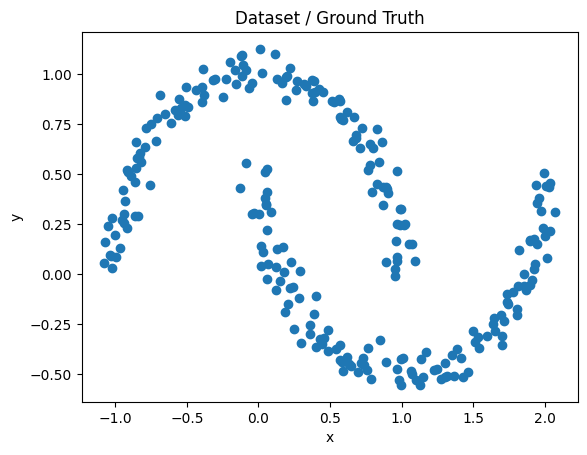

In [4]:
# initialize velocity field
bs = 256
velocity_field = VelocityField(bs=bs, in_size=2, h=64)

# get dataset and visualize data
x1, _ = make_moons(n_samples=bs, noise=0.05, random_state=42)
x1 = torch.tensor(x1, dtype=torch.float32)
visualize_moons(X=x1, title="Dataset / Ground Truth")

In [5]:
# training loop
optimizer = torch.optim.Adam(velocity_field.parameters(), 1e-2)
loss_fn = nn.MSELoss()
num_iters = 10000

for t in range(num_iters):
    optimizer.zero_grad()

    x0 = torch.normal(0.0, 1.0, 
                      size=(velocity_field.bs, 
                      velocity_field.in_size))
    t = torch.rand(x0.shape[0], 1)              # t ~ U[0, 1]
    xt = t * x1 + (1 - t) * x0                  # interpolate to get xt

    ddt = velocity_field( xt, t )
    loss_fn(ddt, x1 - x0).backward()
    optimizer.step()


### Generating Data (sampling)

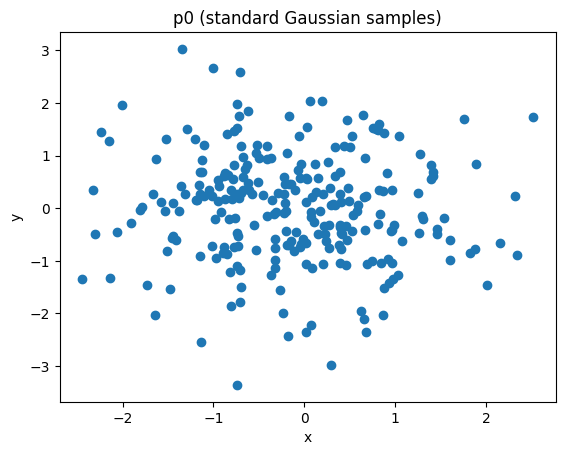

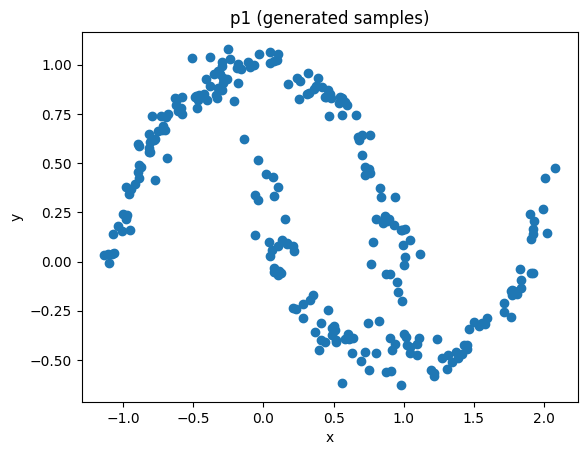

In [6]:
with torch.no_grad():
    sampled, x0 = velocity_field.sample(num_steps=1000)
    visualize_moons(X=x0, title="p0 (standard Gaussian samples)")
    visualize_moons(X=sampled, title="p1 (generated samples)")